In [28]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
# mpl.rcParams['figure.dpi'] = 300
import os
import sys
import pickle
import json
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import nibabel as nib
from nilearn import plotting,image

## I like pathlib's Path objects for managing paths
from pathlib import Path
from sklearn.manifold import TSNE

In [29]:
import sys
## This isn't really ideal, but unless you want to help jwcarr make this package pip installable,
## its understandable why you have to do it this way
sys.path.append("/Users/finnes/Downloads/MantelTest-1.2.10/")

import Mantel

# This function comes from here: https://github.com/jwcarr/MantelTest

# And it **drastically** speeds up the permutation-test step for RSA

## Set directory names

In [30]:
top_dir = Path("./")
data_dir = top_dir /"all_shen268_roi_ts/"
!ls $data_dir | head -5

100610_MOVIE1_7T_AP_shen268_roi_ts.txt
100610_MOVIE1_7T_AP_shen268_roi_ts_gsr.txt
100610_MOVIE2_7T_PA_shen268_roi_ts.txt
100610_MOVIE2_7T_PA_shen268_roi_ts_gsr.txt
100610_MOVIE3_7T_PA_shen268_roi_ts.txt


## Read in behavioral data

#### Read in unrestricted behavioral data:

In [31]:
unres_behav_data = pd.read_csv(top_dir / 'unres_behav_data.csv', 
                         dtype={'Subject': 'str'})
unres_behav_data.set_index("Subject", inplace=True)
print(unres_behav_data.shape)
unres_behav_data.head()

(184, 382)


,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,3T_Full_Task_fMRI,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
Subject,,,,,,,,,,,,,,,,,,,,,
100610,S900,Q08,M,26-30,True,2,1,4,100.0,True,...,2.0,122.25,110.45,0,38.6,84.84,85.31,1.92,1,1.88
102311,S500,Q06,F,26-30,True,1,1,4,100.0,True,...,4.4,122.25,110.45,1,52.2,98.31,99.06,1.80,0,1.80
102816,Q3,Q03,F,26-30,True,1,1,4,100.0,True,...,5.2,122.25,111.41,1,52.6,98.31,97.68,1.72,1,1.68
104416,S900,Q09,F,31-35,True,2,2,4,100.0,True,...,2.8,101.12,87.11,0,38.6,95.36,93.48,1.92,1,1.88
105923,MEG2,Q07,F,31-35,True,2,2,4,100.0,True,...,5.2,122.25,111.41,0,38.6,97.26,96.41,1.88,1,1.84


#### Read in restricted behavioral data (accessing csv file requires applying for access and signing a DUA through HCP):

In [32]:
res_behav_data = pd.read_csv(top_dir / "res_behav_data.csv",
                             dtype={'Subject':str})
res_behav_data = res_behav_data.set_index("Subject")
print(res_behav_data.shape)
res_behav_data.head()

(184, 200)


,Age_in_Yrs,HasGT,ZygositySR,ZygosityGT,Family_ID,Mother_ID,Father_ID,TestRetestInterval,Race,Ethnicity,...,SSAGA_Times_Used_Illicits,SSAGA_Times_Used_Cocaine,SSAGA_Times_Used_Hallucinogens,SSAGA_Times_Used_Opiates,SSAGA_Times_Used_Sedatives,SSAGA_Times_Used_Stimulants,SSAGA_Mj_Use,SSAGA_Mj_Ab_Dep,SSAGA_Mj_Age_1st_Use,SSAGA_Mj_Times_Used
Subject,,,,,,,,,,,,,,,,,,,,,
100610,27,True,NotMZ,DZ,52813_82634,52813,82634,NaN,White,Not Hispanic/Latino,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
102311,26,True,MZ,MZ,51679_81543,51679,81543,NaN,White,Not Hispanic/Latino,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
102816,30,True,MZ,MZ,51418_81283,51418,81283,NaN,Black or African Am.,Not Hispanic/Latino,...,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,3.0
104416,31,True,MZ,MZ,54643_84465,54643,84465,NaN,Asian/Nat. Hawaiian/Othr Pacific Is.,Not Hispanic/Latino,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,3.0
105923,33,True,MZ,,52925_82747,52925,82747,158.0,White,Not Hispanic/Latino,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0


#### While we're at it, import the video timings lookup table:

In [33]:
video_tr_lookup = pd.read_csv(top_dir / "videoclip_tr_lookup.csv")
video_tr_lookup.head()

,clipno_overall,run,clipno_in_run,clip_name,start_tr,stop_tr
0,1,MOVIE1_7T_AP,1,twomen,20,265
1,2,MOVIE1_7T_AP,2,bridgeville,285,506
2,3,MOVIE1_7T_AP,3,pockets,526,714
3,4,MOVIE1_7T_AP,4,overcome,735,798
4,5,MOVIE1_7T_AP,5,testretest1,818,901


#### Join unrestricted + restricted behavioral data into single dataframe:

In [34]:
behav_data = unres_behav_data.join(res_behav_data, how='outer')
## Might consider an assert statement here if you know what shape you're 
## expecting and want to catch throw an error if something's thange
print(behav_data.shape)
# If this throws an assertion error, then the data has an unexpected shape
assert behav_data.shape == (184, 582)

(184, 582)


## Use mother IDs to create list of families; divide subjects into two cohorts ("sets") such that each set contains only one sibling from each family 

This is done to avoid computing ISC between siblings, since we would expect relatedness to affect both brain and behavioral similarity.

In [35]:
## There are more pandas-esque ways to get some of these
## but if this works and is udnerstandable, it's fine
## for example, you could get the siblings list as

new_siblings_list = behav_data.reset_index().groupby('Mother_ID').Subject.unique().values

siblings_list = []

for mother in behav_data["Mother_ID"].unique():
    siblings_list.append(behav_data.query("Mother_ID==@mother").index.values)
    
siblings_list = np.array(siblings_list)

print("There are {} unique families in the dataset".format(len(siblings_list)))

subj_set1 = [family[0] for family in siblings_list]
subj_set2 = [family[1] for family in siblings_list if len(family)>1]

# Make sure subjects are sorted
subj_set1.sort()
subj_set2.sort()

print("There are {} unrelated subjects in set 1".format(len(subj_set1)))
print("There are {} unrelated subjects in set 2".format(len(subj_set2)))

There are 93 unique families in the dataset
There are 93 unrelated subjects in set 1
There are 89 unrelated subjects in set 2


In [36]:
## Here's a pandaseque way to get subject set 1
## but I don't think this is necessarily better or easier to understand
new_subj_set1 = (behav_data
                 .reset_index() # reset the index to make Subject a column
                 .groupby("Mother_ID")
                 .Subject
                 .first() # get the first Subject for each value of Mother_id
                 .sort_values() 
                 .values) # get the results as numpy array instead of a Pandas series
assert (np.array(subj_set1) == new_subj_set1).all()

## I couldn't easily figure out a way different to get subject set 2



In [37]:
full_subj_list = behav_data.index.values
print(len(full_subj_list))

184


## Define a whole bunch of functions

In [38]:
## using some of the Path methods to make this a little cleaner
## you could use it similarly in many of the other of these functions
def get_subjects(data_dir, f_name, full_subj_list):
    
    """
    Takes an original list of subjects and 
    returns a list of subjects for whom the file "f_name" exists 
    (to avoid missing-data issues later)
    """
    
    good_subj_list = []
    
    for subj in full_subj_list:
        f_path = data_dir / (subj + f_name)
        if f_path.exists() and (f_path.stat().st_size > 0):
            good_subj_list.append(subj)
    
    return good_subj_list

In [39]:
data_dir

PosixPath('all_shen268_roi_ts')

In [40]:
f_name = "_MOVIE1_7T_AP_shen268_roi_ts.txt"

good_subj_list = get_subjects(data_dir=data_dir, f_name=f_name, full_subj_list=full_subj_list)
len(good_subj_list)

184

In [41]:
def make_3d_data_mtx(data_dir, f_name, subj_list):
    
    """
    Reads in nodewise timeseries .txt files from list of subjects and stacks them
    to creates data matrix that is nodes x TRs x subjects
    """
    
    # Read in first subject to initialize D:
    subj = subj_list[0]
    f_path = data_dir / (subj + f_name)
    D = pd.read_csv(f_path, sep='\t', header=None).dropna(axis=1).T
    
    # Then read in the rest of the subjects and stack:
    for s, subj in enumerate(subj_list[1:]):
        f_path = data_dir / (subj + f_name)
        tmp = pd.read_csv(f_path, sep='\t', header=None).dropna(axis=1).T
        D = np.dstack((D, tmp))
    
    return D

def make_nodewise_isc_mtx(D, tr_range=None):
    
    """
    Takes data matrix that is nodes x TRs x subjects, and optional tr_range tuple containing a start_tr and stop_tr
    """
    
    # If a TR range was given, restrict data matrix to just those timepoints
    if tr_range:
        D = D[:, tr_range[0]:tr_range[1], :]
    
    # Get dims
    n_nodes, n_trs, n_subs = D.shape
    
    # Initalize result
    out = np.zeros((n_subs, n_subs, n_nodes))
    
    for n in range(n_nodes):
        out[:,:,n] = np.corrcoef(D[n,:,:].T)
        
    return out

def get_clipwise_trs(clip_name, lookup_table = video_tr_lookup):
    
    """
    Returns start_tr and stop_tr for a named clip by consulting video_tr_lookup table
    """

    start_tr = lookup_table.loc[lookup_table["clip_name"]==clip_name,"start_tr"].item()
    stop_tr = lookup_table.loc[lookup_table["clip_name"]==clip_name,"stop_tr"].item() + 5
    return (start_tr, stop_tr)

#### Test out those functions by creating nodewise ISC matrices for the first run of movie data in each cohort separately:

In [42]:
data_dir = Path("./all_shen268_roi_ts/")
f_name = "_MOVIE1_7T_AP_shen268_roi_ts.txt"

good_subs1 = get_subjects(data_dir=data_dir, f_name=f_name, full_subj_list=subj_set1)
D1 = make_3d_data_mtx(data_dir=data_dir, f_name=f_name, subj_list=good_subs1)
ISC1 = make_nodewise_isc_mtx(D1)

good_subs2 = get_subjects(data_dir=data_dir, f_name=f_name, full_subj_list=subj_set2)
D2 = make_3d_data_mtx(data_dir=data_dir, f_name=f_name, subj_list=good_subs2)
ISC2 = make_nodewise_isc_mtx(D2)

In [43]:
print(D1.shape)
print(D2.shape)

(268, 921, 93)
(268, 921, 89)


In [44]:
print(ISC1.shape)
print(ISC2.shape)

(93, 93, 268)
(89, 89, 268)


#### Let's look at one node's ISC matrix to see if it looks reasonable:

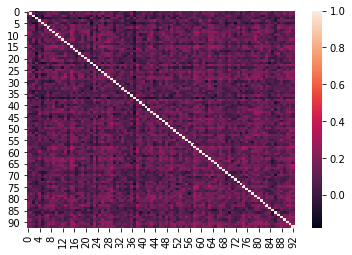

In [45]:
node = 10

sns.heatmap(ISC1[:,:,node])

#### Yep, looks good!

# Inter-subject RSA: Application to real data

First, let's define some functions that will allow us to compute inter-subject behavioral similarity matrices using the various structures illustrated in the "isRSA_simulations" notebook:

In [46]:
def get_nn_pairwise_behav_vct(behav_vct):
    
    """
    Takes a vector of behavioral scores and returns the vectorized upper triangle 
    of a Euclidean distance matrix (i.e., "nearest neighors" similarity structure)
    """
    
    if len(behav_vct.shape)==1: # if it's 1d, reshape it to 2d
        behav_vct = behav_vct.reshape(-1,1)
    
    return np.divide(1,(1 + sp.spatial.distance.pdist(behav_vct)))

In [47]:
def get_annak_pairwise_behav_vct(behav_vct):
    
    """
    Takes a vector of behavioral scores (one per subject) and returns 
    the vectorized upper triangle of a similarity matrix constructed using one formulation of the "AnnaK" principle
    (i.e., high-high pairs are most alike, low-low pairs are most dissimilar, and high-low pairs show intermediate similarity).
    
    """
    
    # Get dims
    n_subs = len(behav_vct)
    
    # Initialize output
    mtx = np.zeros((n_subs,n_subs))

    # Fill in matrix
    for i in range(n_subs):
        for j in range(n_subs):
            mtx[i,j] = behav_vct[i] + behav_vct[j]
    
    # Return just the upper triangle
    vct = mtx[np.triu_indices(mtx.shape[0], k=1)]
    return vct

One final case we haven't touched on yet is when you have a vector of behavior for each individual subject (e.g., responses to individual items on a questionnaire) and you want to compute Euclidean distance between the itemwise answers, rather than the summary score (this is a variant on the nearest-neighbors model):

In [48]:
def get_behav_from_regex(behav_data, behav_regex, likert_map=None):
    
    """
    Gets selected items (via regex) from a behavioral dataframe. For doing Euclidean distance or correlation
    in cases where you have a vector of responses for each subject (rather than a single scalar)
    
    If answers are non-numerical (e.g., Strongly Agree/Agree/etc from a likert scale), 
    you can optionally pass a likert_map to map these to numerical values
    
    Output can be fed directly into get_nn_pairwise_behav_vct
    """
    
    behav_vct = behav_data.filter(regex=behav_regex)
    
    if likert_map:
        behav_vct = behav_vct.replace(likert_map)
    
    return behav_vct

#### Next, let's define a function that actually does the inter-subject RSA:

In [49]:
def do_rsa(nodewise_isc_data, pairwise_behav_vct, n_perms=1000, method='spearman'):
    
    """
    This function computes RSA between brain similarity matrices (ISC) and a behavioral similarity matrix.
    
    Per the output of Mantel.test, the output is a N x 3, where N is the number of nodes, 
    and each row contains the RSA r-value, p-value (based on Mantel permutation test) and z-score, respectively
    """
    
    # Get dims
    n_nodes = nodewise_isc_data.shape[2]
    
    # Initialize output
    result = []

    # Enter node loop
    for nn in range(n_nodes):
        isc_vct = nodewise_isc_data[:,:,nn][np.triu_indices(nodewise_isc_data.shape[0], k=1)]
        tmp = Mantel.test(isc_vct, pairwise_behav_vct, perms=n_perms, method=method)
        result.append(tmp)
            
    return result

This is an exploratory analysis, and we expect that effects will subtle, so Bonferroni correction across 268 nodes is probably too strict. That said, we want to make every effort to ensure that we are visualizing and interpreting effects that are replicable.

Therefore, for every model we run, our pipeline will be as follows:
    - compute intersubject-RSA separately in each cohort
    - plot RSA values across the two cohorts to see how replicable effects are  
    - only visualize/interpret nodes that meet statistical significance in both cohorts
    
The following functions implement that workflow.

In [50]:
def set_aspect_ratio(ax):
    
    """
    helper function to make square axes with equal x and y ranges
    """
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    both_min = np.min([xmin, ymin])
    both_max = np.max([xmax, ymax])
    ax.set_xlim((both_min, both_max))
    ax.set_ylim((both_min, both_max))
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    
    ## might consider returning ax at the end of this function, 
    ## but it works fine without doing that
    ## it can just make the flow where this is used a little clearer

In [51]:
def plot_set1_vs_set2(result1, result2, tuple_index=0, ax=None, opacity=1, color="gray", p_alpha = 0.05, sig_color=None):
    
    # If no pre-existing axis was specified, make a new fig/ax
    ax = ax or plt.gca()
    
    # Set up axis with identity line
    line = mlines.Line2D([0, 1], [0, 1], color='gray', linestyle='--')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    # sns.set_style("white")
    
    if sig_color:
        colors = []
        sizes = []
        
        surv1 = np.array([x[1] for x in result1]) < p_alpha # does it survive in result 1?
        surv2 = np.array([x[1] for x in result2]) < p_alpha # does it survive in result 2?
        signs = [np.sign(result1[x][0])==np.sign(result2[x][0]) 
                 for x in range(len(result1))] # are the signs the same?
        surv_bool = np.logical_and.reduce((surv1, surv2, signs)) # combine all three above

        for node in range(len(result1)):
            if surv_bool[node]:
                colors.append(sig_color)
                sizes.append(40)
            else:
                colors.append(color)
                sizes.append(4)
    else:
        colors = color
        sizes = 4
    
    # Make scatter plot
    ax.scatter([x[tuple_index] for x in result1],
               [x[tuple_index] for x in result2], 
               s=sizes, color=colors, alpha=opacity)
    ax.set_xlabel("subj_set1 RSA r-value")
    ax.set_ylabel("subj_set2 RSA r-value")
    # ax.set_title(title)
    ax.axhline(y=0, color="gray")
    ax.axvline(x=0, color="gray")

    # Make aspect ratio/scaling equal
    set_aspect_ratio(ax)
    
    # Make ticks the same
    ax.set_xticks(ax.get_yticks())
    ## ax.set_xticklabels(ax.get_yticklabels())
    ## this seems like it should work, but unfortunately if you look at what
    ## ax.get_yticklabels() returns, it's <a list of 6 Text yticklabel objects>
    ## each Text object has a .get_text() method, so here's what you have to do
    ax.set_xticklabels([aa.get_text() for aa in ax.get_yticklabels()])
    

    # Annotate with r-value
    r = sp.stats.pearsonr([x[tuple_index] for x in result1],
                          [x[tuple_index] for x in result2])[0]
    ax.annotate(f"r = {r:.2f}", xy=(0.1,0.9), xycoords="axes fraction", fontsize=14)
    
    return ax

In [52]:
def get_intersection(result1, result2, alpha=0.05):
    
    """
    This function assumes you are passing a "results" tuple with r-values in the first column 
    and p-values in the second column (e.g., output of do_rsa). It returns nodes that pass the statistical threshold in both cohorts.
    """
    
    surv1 = np.array([x[1] for x in result1]) < alpha # does it survive in result 1?
    surv2 = np.array([x[1] for x in result2]) < alpha # does it survive in result 2?
    signs = [np.sign(result1[x][0])==np.sign(result2[x][0]) for x in range(len(result1))] # are the signs the same?
    
    surv_bool = np.logical_and.reduce((surv1, surv2, signs))
    surv_nodes = np.where(surv_bool)[0]
    
    return surv_bool

In [53]:
def color_rois(values):
    
    """
    This function assumes you are passing a vector "values" with the same length as the number of nodes in the atlas.
    """
    
    shen268 = nib.load((top_dir / "shen_2mm_268_parcellation.nii.gz").as_posix())
    shen268_data = shen268.get_data()
    img = np.zeros(shen268_data.shape)

    for roi in range(len(values)):
        itemindex = np.where(shen268_data==roi+1) # find voxels in this node (add 1 to account for zero-indexing)
        img[itemindex] = values[roi] # color them by the desired value 

    affine = shen268.affine
    img_nii = nib.Nifti1Image(img, affine)
    
    return img_nii

#### Ok, let's put it all together:

In [54]:
def isrsa_wrapper(behav_name, clip_name, models, GSR=0, n_perms=1000):

    ## Might consider moving input validation stuff up to the top
    ## so that it fails quickly if passed bad inputs
    ## better yet, if you make it a dictionary, you can simplify the code below
    
    known_models = {"NN":get_nn_pairwise_behav_vct,
                    "AnnaK":get_annak_pairwise_behav_vct}
    
    for model in models:
        if model not in known_models.keys():
            raise ValueError(f"The povided list of models includes {model},"
                             f"which is not in the list of accepted models: {known_models.keys()}")
            
    # Figure out which run this clip is in
    if "MOVIE" in clip_name: #...unless it's just MOVIE1, MOVIE2, MOVIE3 or MOVIE4, in which case use the whole run
        run_name = clip_name
        tr_range = None
    else:
        run_name = video_tr_lookup.query('clip_name==@clip_name')["run"].values[0]
        tr_range = get_clipwise_trs(clip_name)

    # Assemble full filename
    if GSR==0:
        f_suffix = "_shen268_roi_ts.txt"
    elif GSR==1:
        f_suffix = "_shen268_roi_ts_gsr.txt"
    f_name = "_" + run_name + f_suffix

    # Get final list of subjects (based on who has this run)
    good_subs1 = get_subjects(data_dir=data_dir, f_name=f_name, full_subj_list=subj_set1)
    good_subs2 = get_subjects(data_dir=data_dir, f_name=f_name, full_subj_list=subj_set2)

    # Read in timeseries data
    D1 = make_3d_data_mtx(data_dir=data_dir, f_name=f_name, subj_list=good_subs1)
    D2 = make_3d_data_mtx(data_dir=data_dir, f_name=f_name, subj_list=good_subs2)

    # Make nodewise ISC matrices
    ISC1 = make_nodewise_isc_mtx(D1, tr_range)
    ISC2 = make_nodewise_isc_mtx(D2, tr_range)

    # Get vectors of behavior
    behav_vct1 = behav_data.loc[good_subs1, behav_name].values.reshape(-1,1)
    behav_vct2 = behav_data.loc[good_subs2, behav_name].values.reshape(-1,1)
    
    # Do the actual RSA
    results_dict = {}
    
    for model in models:
        results_dict[model] = {}
            
        result1 = do_rsa(ISC1, known_models[model](behav_vct1), n_perms=n_perms)
        result2 = do_rsa(ISC2, known_models[model](behav_vct2), n_perms=n_perms)

        results_dict[model]["result1"] = result1
        results_dict[model]["result2"] = result2
    
    return results_dict

In [59]:
def figure_wrapper(results_dict, figsize=(10,5), alpha = 0.05, color_names = None, flip_left = False):
    
    # Get model names
    models = list(results_dict.keys())
    
    # Generate custom colormap
    legend_handles = models + ["Both {} and {}".format(models[0], models[1])]
    color_dict = {}
    
    if color_names is None:
        color_names = ["tab:blue", "tab:red", "tab:purple"]
    color_dict = dict(zip(legend_handles, color_names))

    # cmap = colors.ListedColormap(color_dict.values())
    cmap = mpl.colors.ListedColormap([color_dict.values()])
    bounds = [1,2,3,4]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, clip=True)
    
    # Set up figure and subplots
    n_models = len(models)

    fig = plt.figure(figsize=figsize)
    # gs = mpl.gridspec.GridSpec(2, n_models, figure=fig)
    gs = mpl.gridspec.GridSpec(nrows=1, ncols=n_models+1, figure = fig, width_ratios=[1,1,3])
    
    xmin = []
    xmax = []
    ymin = []
    ymax = []
    
    model_results = pd.DataFrame(columns=models)
    
    for m, model in enumerate(models):
        
        # Create an axis for the scatterplot for this model
        ax = fig.add_subplot(gs[0,m])
        
        result1 = results_dict[model]["result1"]
        result2 = results_dict[model]["result2"]
        
        # Make scatterplot
        plot_set1_vs_set2(result1, result2, p_alpha = alpha, sig_color=color_dict[model], ax=ax)
        set_aspect_ratio(ax)
        ax.set_title(model)
        
        # record scatterplot limiits
        sp_xmin, sp_xmax = ax.get_xlim()
        sp_ymin, sp_ymax = ax.get_ylim()
        xmin.append(sp_xmin)
        xmax.append(sp_xmax)
        ymin.append(sp_ymin)
        ymax.append(sp_ymax)
        
        # Get intersection of subj_set1 and subj_set2
        surv_nodes = get_intersection(result1, result2, alpha=alpha)
        model_results[model] = surv_nodes
    
    # set scatter plot limits
    xmin = np.min(xmin)
    xmax = np.max(xmax)
    ymin = np.min(ymin)
    ymax = np.max(ymax)
    for ax in fig.get_axes():
        ax.set_xlim((xmin, xmax))
        ax.set_ylim((ymin, ymax))
        ax.set_xticks(ax.get_yticks())
        ax.set_xticklabels([f"{aa:0.1f}" for aa in ax.get_xticks()])
        #print([bb.get_text() for bb in ax.get_yticklabels()])
        #print([bb.get_text() for bb in ax.get_xticklabels()])
    
    # Make glass brain axis
    fig.subplots_adjust(bottom=0.1, right = 1.03)
    # ax_glassbrain = fig.add_subplot(gs[1,:]) # for glass brain figure
    ax_glassbrain = fig.add_subplot(gs[-1]) # for glass brain figure

    # Color ROIs that were significant in each model separately
    display_mode = 'lzr'
    bounds = [0.5,1.5]

    for model in models:
        cmap = mpl.colors.ListedColormap([color_dict[model]])
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        img = color_rois(model_results[model])
        plotting.plot_glass_brain(img, axes=ax_glassbrain, cmap=cmap, norm=norm, display_mode=display_mode)
        
    # Color ROIs that were significant in both models
    cmap = mpl.colors.ListedColormap([color_dict["Both {} and {}".format(models[0], models[1])]])
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    img_overlap = color_rois(model_results[models[0]] & model_results[models[1]])
    plotting.plot_glass_brain(img_overlap, axes=ax_glassbrain, cmap=cmap, norm=norm, display_mode=display_mode)
    ## This is the best workaround I could come up with for the orientation problem
    ## Here's the issue: https://github.com/nilearn/nilearn/issues/1815
    if flip_left:
        axi = fig.get_axes()[-3]
        xmin,xmax = axi.get_xlim()
        axi.set_xlim((xmax,xmin))
    # Make legend
    patches = [ mpl.patches.Patch(color=color_names[i], label="{:s}".format(legend_handles[i]) ) for i in range(len(legend_handles)) ]
    ax_glassbrain.legend(handles=patches, ncol=3) # , loc='upper center', bbox_to_anchor=(0.5,0))
    
    return fig

As a first pass, let's see how the NN and AnnaK models compare for looking at how ISC relates to working memory (ListSort_Unadj). A priori we might expect that subjects who have better working memory would look more similar to one another during movie watching, so the AnnaK model would capture this better.

/Users/finnes/anaconda3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/Users/finnes/.local/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/Users/finnes/anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/Users/finnes/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

Text(0.3, 0.98, 'ListSort_Unadj')

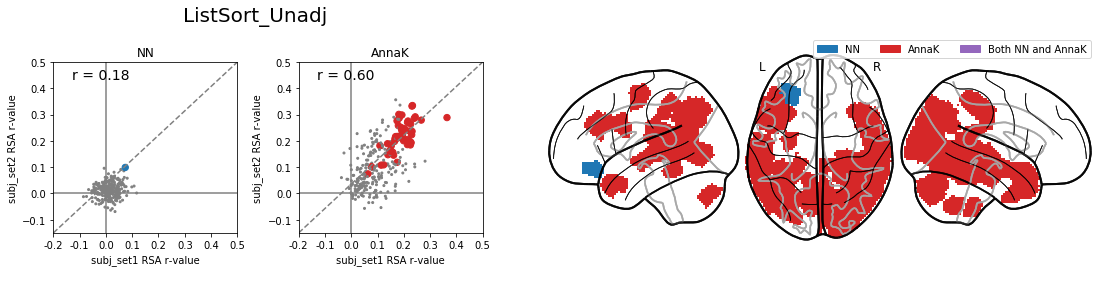

In [61]:
behav_name = "ListSort_Unadj"
clip_name = "MOVIE1_7T_AP"
models = ["NN", "AnnaK"]
alpha = 0.05

results_dict = isrsa_wrapper(behav_name = behav_name, clip_name = clip_name, models = models)
fig = figure_wrapper(results_dict, figsize = (16,4), alpha = alpha, flip_left = True)

fig.suptitle(behav_name, x = 0.3, fontsize = 20)

In [62]:
intersection = np.zeros((268, len(models)))

for m, model in enumerate(models):

    surv_nodes = get_intersection(results_dict[model]["result1"], results_dict[model]["result2"], alpha=alpha)
    print("{} nodes survived in the {} model".format(surv_nodes.sum(), model))
    
    intersection[:,m] = surv_nodes

print("The intersection between the two models was {}".format(intersection.sum(axis=1).tolist().count(2)))

1 nodes survived in the NN model
50 nodes survived in the AnnaK model
The intersection between the two models was 0


So we see that compared to the NN model, the "AnnaK" model yields larger effect sizes that are more consistent across the two cohorts, and that it is more sensitive in that it picks up more nodes (purple nodes are those that were picked up by both models, while red nodes were picked up only by the AnnaK model.

What about for traits that are even more value-agnostic, like personality? Would we expect something like extraversion to be more of an NN-type or an AnnaK-type? Or maybe it could be either, depending on the brain region? Let's run our RSA models on the Big Five traits from the NEO Five-Factor Inventory: Agreeableness (A), Extraversion (E), Conscientiousness (C), Openness (O), and Neuroticism (N):

In [ ]:
NEOFAC_traits = ["NEOFAC_A", "NEOFAC_E", "NEOFAC_C", "NEOFAC_O", "NEOFAC_N"]
clip_name = "MOVIE1_7T_AP"
models = ["NN", "AnnaK"]
alpha = 0.05

for trait in NEOFAC_traits:
    
    behav_name = trait

    # Do analysis
    results_dict = isrsa_wrapper(behav_name = behav_name, clip_name = clip_name, models = models, n_perms=10000)
    
    # Print stuff
    intersection = np.zeros((268, len(models)))
    for m, model in enumerate(models):
        surv_nodes = get_intersection(results_dict[model]["result1"], results_dict[model]["result2"], alpha=alpha)
        print("{} nodes survived in the {} model".format(surv_nodes.sum(), model))
        intersection[:,m] = surv_nodes
    print("The intersection between the two models was {}".format(intersection.sum(axis=1).tolist().count(2)))

    # Make figure
    fig = figure_wrapper(results_dict, figsize = (16,4), alpha = alpha, flip_left = True)

    fig.suptitle(behav_name, x = 0.3, fontsize = 20)

These results are largely underwhelming -- a few nodes show up here and there, but overall the results are weak and not very replicable across the two cohorts.

**BUT!** let's not forget that these 5 traits are just summary scores. Each subject filled out a 60-item questionnnaire. What if we formulated the NN model as Euclidean distance not between the summary scores, but between the entire vector of itemwise responses?

In [ ]:
behav_regex = "NEORAW_" # each individual item starts with this prefix
likert_map = {"SD": 1, "D": 2, "N": 3, "A": 4, "SA": 5}

behav_vct1 = get_behav_from_regex(behav_data=behav_data.loc[good_subs1, :], behav_regex=behav_regex, likert_map=likert_map)
behav_vct2 = get_behav_from_regex(behav_data=behav_data.loc[good_subs2, :], behav_regex=behav_regex, likert_map=likert_map)
result1_itemwise = do_rsa(ISC1, get_nn_pairwise_behav_vct(behav_vct1))
result2_itemwise = do_rsa(ISC2, get_nn_pairwise_behav_vct(behav_vct2))

# Set up plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,5), gridspec_kw={'width_ratios': [1, 1, 3]})

# Make scatterplot
plot_set1_vs_set2(result1_itemwise, result2_itemwise, sig_color="tab:green", ax=ax1)
set_aspect_ratio(ax1)
ax1.set_title('NEOFAC NN: Itemwise')

# Make glass brain plot
# make color map
bounds = [0.5,1.5]
cmap = mpl.colors.ListedColormap(["tab:green"])
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        
img = color_rois(get_intersection(result1_itemwise, result2_itemwise))
plotting.plot_glass_brain(img, cmap=cmap, norm=norm, axes=ax3, display_mode = 'lzr')

plt.tight_layout()

In [ ]:
# Set up plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,4), gridspec_kw={'width_ratios': [1, 1, 3]})

# Make scatterplot
plot_set1_vs_set2(result1_itemwise, result2_itemwise, sig_color="tab:blue", ax=ax1)
set_aspect_ratio(ax1)
ax1.set_title('NEOFAC NN: Itemwise')

fig.subplots_adjust(bottom=0.1)

# Make glass brain plot
# make color map
bounds = [0.5,1.5]
cmap = mpl.colors.ListedColormap(["tab:blue"])
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        
img = color_rois(get_intersection(result1_itemwise, result2_itemwise))
plotting.plot_glass_brain(img, cmap=cmap, norm=norm, axes=ax3, display_mode = 'lzr')

fig.suptitle('NEOFAC_all', x = 0.3, fontsize=20)

# plt.tight_layout()

Now we see that pairs of subjects that give similar item-level responses to the questionnaire look more similar during movie watching in several brain regions (especially in the cerebellum), regardless of their overall levels of each of the five summary dimensions. Interesting! 


In [ ]:
surv_nodes = get_intersection(result1_itemwise, result2_itemwise, alpha=alpha)
print("{} nodes survived".format(surv_nodes.sum()))

In [ ]:
shen268_labels = pd.read_csv(top_dir /'xilin_268parc_labels.csv')
shen268_labels.set_index("Node_No", inplace=True)
shen268_labels.head()

In [ ]:
shen268_label_dict = {}
shen268_label_dict["BrodLabels"] = {
	1 : 'PrimSensory (1)',   4 : 'PrimMotor (4)',
	5 : 'SensoryAssoc (5)',  6 : 'BA6',
	7 : 'BA7',              8 : 'BA8',
	9 : 'BA9',              10 : 'BA10',
	11 : 'BA11',            13 : 'Insula (13)',
	14 : 'BA14',            17 : 'PrimVisual (17)',
	18 : 'VisualAssoc (18)', 19 : 'BA19',
	20 : 'BA20',            21 : 'BA21',
	22 : 'BA22',            23 : 'BA23',
	24 : 'BA24',            25 : 'BA25',
	30 : 'BA30',            31 : 'BA31',
	32 : 'BA32',            34 : 'BA34',
	36 : 'Parahip (36)',     37 : 'Fusiform (37)',
	38 : 'BA38',            39 : 'BA39',
	40 : 'BA40',            41 : 'PrimAuditory (41)',
	44 : 'BA44',            45 : 'BA45',
	46 : 'BA46',            47 : 'BA47',
	48 : 'Caudate (48)',     49 : 'Putamen (49)',
	50 : 'Thalamus (50)',    51 : 'GlobPal (51)',
	52 : 'NucAccumb (52)',   53 : 'Amygdala (53)',
	54 : 'Hippocampus (54)', 55 : 'Hypothalamus (55)',
	58 : 'BrainStem',        57 : 'Cerebellum',
    }

In [ ]:
for label in shen268_labels.loc[surv_nodes,"BrodLabel"].values:
    print(shen268_label_dict["BrodLabels"][label])